In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import các thư viện

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
import io
import cv2
# import anvil.media

In [3]:

# Khai báo đường dẫn đến thư mục annotations
annotations_path = '/content/drive/MyDrive/DL/Dataset/Annotations'
# Khai báo đường dẫn đến thư mục dataset trong thư mục dataset
dataset_path = '/content/drive/MyDrive/DL/Dataset/Image'


##### Tạo file chứa bounding box

In [ ]:
import csv
from lxml import etree

# Danh sách các cặp thư mục XML và file CSV tương ứng
datasets = [
    {'xml_dir': '/content/drive/MyDrive/DL/Dataset/labelImg/Cripsy_Vietnamese_Pancake',
     'csv_file': '/content/drive/MyDrive/DL/Dataset/Annotations/Cripsy_Vietnamese_Pancake.csv'},

    {'xml_dir': '/content/drive/MyDrive/DL/Dataset/labelImg/Floating_Rice_Cake',
     'csv_file': '/content/drive/MyDrive/DL/Dataset/Annotations/Floating_Rice_Cake.csv'},

    {'xml_dir': '/content/drive/MyDrive/DL/Dataset/labelImg/Pho',
     'csv_file': '/content/drive/MyDrive/DL/Dataset/Annotations/Pho.csv'},

    {'xml_dir': '/content/drive/MyDrive/DL/Dataset/labelImg/Banh_Mi',
     'csv_file': '/content/drive/MyDrive/DL/Dataset/Annotations/Banh_Mi.csv'},

    {'xml_dir': '/content/drive/MyDrive/DL/Dataset/labelImg/Banh_Cuon',
     'csv_file': '/content/drive/MyDrive/DL/Dataset/Annotations/Banh_Cuon.csv'}
]

# Lặp qua từng cặp thư mục XML và file CSV
for dataset in datasets:
    XML_DIR = dataset['xml_dir']
    CSV_FILE = dataset['csv_file']

    # Tạo file CSV và ghi tiêu đề cột
    with open(CSV_FILE, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class'])

        # Lấy danh sách file XML trong thư mục
        filenames = os.listdir(XML_DIR)
        filenames.sort()  # Sắp xếp danh sách file để duyệt theo thứ tự

        for filename in filenames:
            if filename.endswith('.xml'):
                xml_path = os.path.join(XML_DIR, filename)

                # Đọc file XML
                tree = etree.parse(xml_path)
                root = tree.getroot()

                # Trích xuất thông tin
                img_filename = root.find('filename').text
                object_elem = root.find('object')
                object_name = object_elem.find('name').text
                xmin = int(object_elem.find('bndbox/xmin').text)
                ymin = int(object_elem.find('bndbox/ymin').text)
                xmax = int(object_elem.find('bndbox/xmax').text)
                ymax = int(object_elem.find('bndbox/ymax').text)

                # Ghi dòng vào file CSV
                writer.writerow([img_filename, xmin, ymin, xmax, ymax, object_name])

    print(f"Đã tạo file CSV tại: {CSV_FILE}")


Đã tạo file CSV tại: /content/drive/MyDrive/DL/Dataset/Annotations/Cripsy_Vietnamese_Pancake.csv
Đã tạo file CSV tại: /content/drive/MyDrive/DL/Dataset/Annotations/Floating_Rice_Cake.csv
Đã tạo file CSV tại: /content/drive/MyDrive/DL/Dataset/Annotations/Pho.csv
Đã tạo file CSV tại: /content/drive/MyDrive/DL/Dataset/Annotations/Banh_Mi.csv
Đã tạo file CSV tại: /content/drive/MyDrive/DL/Dataset/Annotations/Banh_Cuon.csv


##### Hiển thị hình ảnh

In [6]:
# List of image directories for each class
image_dirs = [
    {'class_name': 'BanhCuon', 'dir': '/content/drive/MyDrive/DL/Dataset/Image/BanhCuon'},
    {'class_name': 'BanhMi', 'dir': '/content/drive/MyDrive/DL/Dataset/Image/BanhMi'},
    {'class_name': 'CripsyVietnamesePancake', 'dir': '/content/drive/MyDrive/DL/Dataset/Image/CripsyVietnamesePancake'},
    {'class_name': 'FloatingRiceCake', 'dir': '/content/drive/MyDrive/DL/Dataset/Image/FloatingRiceCake'},
    {'class_name': 'Pho', 'dir': '/content/drive/MyDrive/DL/Dataset/Image/Pho'}
]

def display_images(image_dir, class_name, num_images=3):
    filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    filenames = sorted(filenames)[:num_images]

    plt.figure(figsize=(10, 5))
    plt.suptitle(f'{class_name}', fontsize=16)

    for i, filename in enumerate(filenames):
        img_path = os.path.join(image_dir, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for item in image_dirs:
    display_images(item['dir'], item['class_name'])


Output hidden; open in https://colab.research.google.com to view.

##### Đọc ảnh đầu vào

In [7]:

def get_data(width, height):
    # Đường dẫn đến thư mục dataset
    dataset_path = '/content/drive/MyDrive/DL/Dataset/Image'

    images = []
    labels = []
    bboxes = []

    # Lặp qua các thư mục con trong dataset
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        # Lặp qua các hình ảnh trong thư mục con
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            # Xử lý dữ liệu hình ảnh ở đây (ví dụ: sử dụng PIL)
            image = Image.open(image_path)
            image = image.resize((width, height))
            # Lưu trữ hình ảnh
            images.append(image)
            # Lưu trữ nhãn và hộp giới hạn (bbox)
            labels.append(class_name)
            bboxes.append((0, 0, width, height))  # Ví dụ: hộp giới hạn toàn bộ hình ảnh

    return images, labels, bboxes

images, labels, bboxes = get_data(224, 224)
print("Data:", len(images))

Data: 275


In [8]:

def get_data(width, height, test_size=0.2):
    # Đường dẫn đến thư mục dataset
    dataset_path = '/content/drive/MyDrive/DL/Dataset/Image'

    images = []
    labels = []
    bboxes = []

    # Lặp qua các thư mục con trong dataset
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        # Lặp qua các hình ảnh trong thư mục con
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            # Xử lý dữ liệu hình ảnh ở đây (ví dụ: sử dụng PIL)
            image = Image.open(image_path)
            image = image.resize((width, height))
            # Lưu trữ hình ảnh
            images.append(image)
            # Lưu trữ nhãn và hộp giới hạn (bbox)
            labels.append(class_name)
            bboxes.append((0, 0, width, height))  # Ví dụ: hộp giới hạn toàn bộ hình ảnh

    # Chia dữ liệu thành tập huấn luyện và tập validation
    X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=test_size, random_state=42)

    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = get_data(224, 224, test_size=0.2)
print("Data:", len(X_train) + len(X_valid))
print("Train:", len(X_train))
print("Valid:", len(X_valid))

Data: 275
Train: 220
Valid: 55


##### Model
* Use VGG16 transfer learning

In [9]:

def get_model(height, width, channel, nclasses):
    # Load VGG16
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channel))
    # Đóng băng các tầng
    vgg.trainable = False
    # Flatten
    flatten = vgg.output
    flatten = Flatten()(flatten)
    # Nhánh label
    label = Dense(512, activation='relu')(flatten)
    label = Dense(256, activation='relu')(label)
    label = Dense(nclasses, activation="softmax", name="class_label")(label)
    # Nhánh bounding box
    bbox = Dense(512, activation='relu')(flatten)
    bbox = Dense(256, activation='relu')(bbox)
    bbox = Dense(4, activation="sigmoid", name="bounding_box")(bbox)
    # Xây dựng model
    model = Model(inputs=vgg.input, outputs=[label, bbox])


    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"},
        metrics={"class_label": "accuracy", "bounding_box": "mse"},
        loss_weights={"class_label": 1.0, "bounding_box": 1.0}
    )

    return model

height, width, channel, nclasses = (224, 224, 3, 5)
model = get_model(height, width, channel, nclasses)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 40,670,793 (155.15 MB)

 Trainable params: 25,956,105 (99.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


##### Xử lý ảnh đầu vào

In [10]:
def get_data(height, width):
    images = []
    labels = []
    bboxes = []
    missing_images = []  # List to store missing images for debugging

    ANNOTATION_PATH = '/content/drive/MyDrive/DL/Dataset/Annotations'
    IMAGE_PATH = '/content/drive/MyDrive/DL/Dataset/Image'

    csvFileNames = os.listdir(ANNOTATION_PATH)

    for csvFileName in csvFileNames:
        csvPath = os.path.join(ANNOTATION_PATH, csvFileName)
        rows = open(csvPath).read().strip().split("\n")

        for idx, row in enumerate(rows):
            if idx == 0:
                continue  # Skip the header row

            filename, x1, y1, x2, y2, label = row.split(",")

            imagePath = os.path.join(IMAGE_PATH, label, filename)
            image = cv2.imread(imagePath)
            if image is None:  # Add a check for missing image files
                print(f"Warning: Missing image file - {imagePath}")
                missing_images.append(imagePath)  # Add missing file path to list
                continue  # Skip this entry

            # If the image exists, process it
            h, w, depth = image.shape
            x1 = float(x1) / w
            y1 = float(y1) / h
            x2 = float(x2) / w
            y2 = float(y2) / h

            image = load_img(imagePath, target_size=(height, width))
            image = img_to_array(image)

            images.append(image)
            labels.append(label)
            bboxes.append((x1, y1, x2, y2))

    print("Missing images:", missing_images)  # Print the missing images list for debugging
    return images, labels, bboxes

def preprocess_input(images, labels, bboxes):
    images = [image / 255. for image in images]

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    # Save class_names to JSON file
    class_names = lb.classes_.tolist()
    with open("/content/drive/MyDrive/DL/Dataset/class_names.json", "w") as f:
        json.dump(class_names, f)

    print('Classes: ', lb.classes_)

    images_train, images_valid, labels_train, labels_valid, bboxes_train, bboxes_valid = train_test_split(
        images, labels, bboxes, test_size=0.2, random_state=42)

    return (images_train, labels_train, bboxes_train), (images_valid, labels_valid, bboxes_valid)

if __name__ == "__main__":
    images, labels, bboxes = get_data(224, 224)
    print("Total images found: ", len(images))

    (images_train, labels_train, bboxes_train), (images_valid, labels_valid, bboxes_valid) = preprocess_input(images, labels, bboxes)
    print("Training set size: ", len(images_train))
    print("Validation set size: ", len(images_valid))


Missing images: []
Total images found:  275
Classes:  ['BanhCuon' 'BanhMi' 'CripsyVietnamesePancake' 'FloatingRiceCake' 'Pho']
Training set size:  220
Validation set size:  55


[0 0 1 0 0]


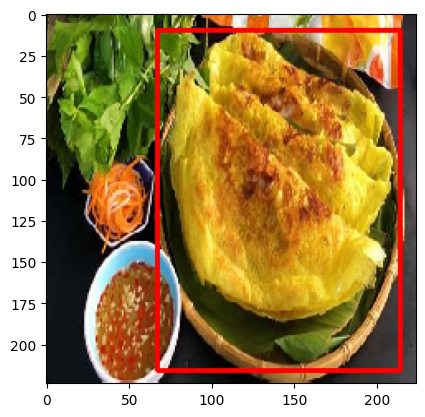

In [11]:

    img = images_train[0]
    img = (img * 255).astype(np.uint8)
    h, w, _ = img.shape
    bboxes = bboxes_train[0]
    x1, y1, x2, y2 = bboxes
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)

    print(labels_train[0])

    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(img)

    plt.savefig('/content/drive/MyDrive/DL/test.jpg')

##### Training

In [12]:

def get_data(width, height):
    # Tải dữ liệu
    # Thực hiện xử lý dữ liệu và chia thành tập huấn luyện và tập validation
    return images_train, images_valid, labels_train, labels_valid, bboxes_train, bboxes_valid

def get_model(height, width, channel, nclasses):
    # Load và cấu hình mô hình
    # Xây dựng mô hình
    # Compile mô hình
    return model

if __name__ == "__main__":
    # Kích thước dữ liệu
    height, width, channel, nclasses = (224, 224, 3, 5)

    # Load data
    images_train, images_valid, labels_train, labels_valid, bboxes_train, bboxes_valid = get_data(width, height)

    # Load model
    model = get_model(height, width, channel, nclasses)

    # Huấn luyện model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss={"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"},
        metrics={"class_label": "accuracy", "bounding_box": "mse"},
        loss_weights={"class_label": 1.0, "bounding_box": 1.0}
    )

    history = model.fit(
    x=np.array(images_train),
    y=[np.array(labels_train), np.array(bboxes_train)],
    validation_data=(np.array(images_valid), [np.array(labels_valid), np.array(bboxes_valid)]),
    batch_size=32,
    epochs=50,
    verbose=1
)

    # Lưu model
    model.save("/content/drive/MyDrive/DL/my_model.keras")



Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - bounding_box_mse: 0.0660 - class_label_accuracy: 0.2553 - loss: 1.9064 - val_bounding_box_mse: 0.0149 - val_class_label_accuracy: 0.5818 - val_loss: 1.0940
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - bounding_box_mse: 0.0167 - class_label_accuracy: 0.8142 - loss: 0.7509 - val_bounding_box_mse: 0.0146 - val_class_label_accuracy: 0.8727 - val_loss: 0.6011
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - bounding_box_mse: 0.0139 - class_label_accuracy: 0.9706 - loss: 0.2743 - val_bounding_box_mse: 0.0131 - val_class_label_accuracy: 0.8364 - val_loss: 0.5594
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - bounding_box_mse: 0.0139 - class_label_accuracy: 1.0000 - loss: 0.1030 - val_bounding_box_mse: 0.0128 - val_class_label_accuracy: 0.8727 - val_loss: 0.4336
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - bounding_box_mse: 0.0129 - class_label_accuracy: 1.0000 - loss: 0.0464 - val_bounding_box_mse: 0.0127 - val_class_labe

##### Trực quan quá trình huấn luyện

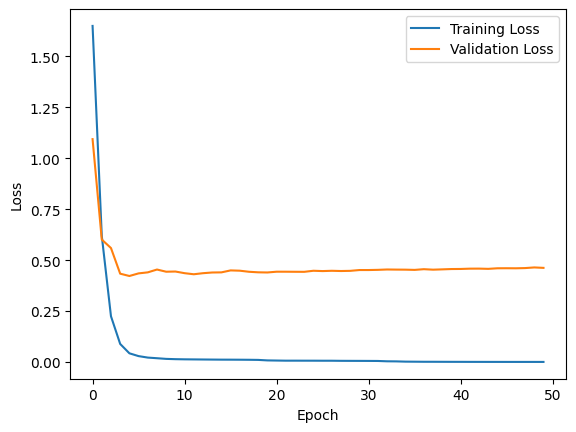

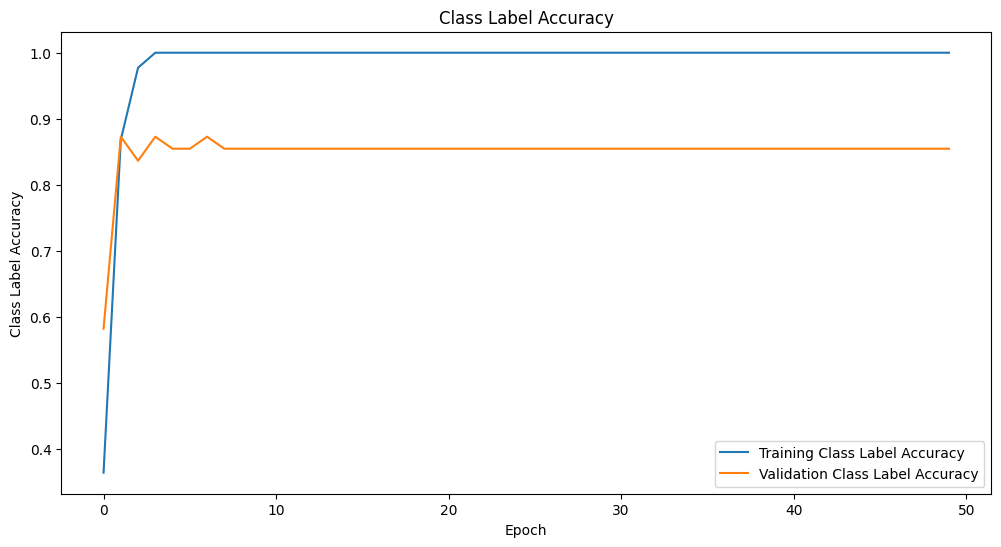

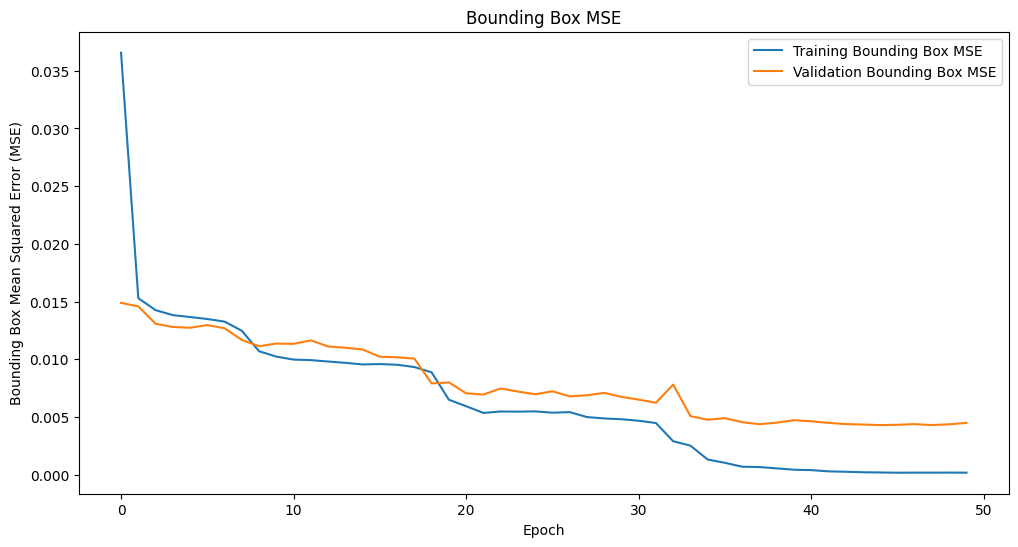

In [13]:
 # Vẽ biểu đồ loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Vẽ biểu đồ Class Label Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['class_label_accuracy'], label='Training Class Label Accuracy')
plt.plot(history.history['val_class_label_accuracy'], label='Validation Class Label Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Class Label Accuracy')
plt.legend()
plt.title('Class Label Accuracy')
plt.show()

# Vẽ biểu đồ Bounding Box MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['bounding_box_mse'], label='Training Bounding Box MSE')
plt.plot(history.history['val_bounding_box_mse'], label='Validation Bounding Box MSE')
plt.xlabel('Epoch')
plt.ylabel('Bounding Box Mean Squared Error (MSE)')
plt.legend()
plt.title('Bounding Box MSE')
plt.show()


##### Xác định một hàm  dự đoán

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


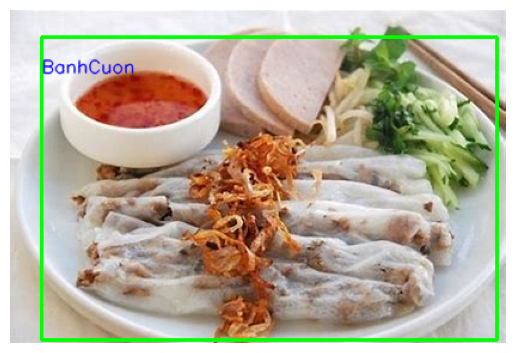

In [25]:

def predict():
    model = load_model('/content/drive/MyDrive/DL/my_model.keras')

    with open("/content/drive/MyDrive/DL/Dataset/class_names.json", "r") as f:
        class_names = json.load(f)

    image_path = '/content/drive/MyDrive/DL/Dataset/Image/BanhCuon/Image_02.jpg'
    target_size = (224, 224)
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image /= 255.0
    image = np.expand_dims(image, 0)

    # Dự đoán
    (label_preds, box_preds) = model.predict(image)
    box_preds = box_preds[0]
    label_preds = label_preds[0]

    (x1, y1, x2, y2) = box_preds
    #đọc hình ảnh
    image = cv2.imread(image_path)
    img_h, img_w, _ = image.shape

    x1 = int(x1 * img_w)
    y1 = int(y1 * img_h)
    x2 = int(x2 * img_w)
    y2 = int(y2 * img_h)

    # Vẽ bounding box
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    predicted_class = class_names[np.argmax(label_preds)]

    org = (x1, y1 + 30)
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    color = (255, 0, 0)
    thickness = 1
    lineType = cv2.LINE_AA

    image = cv2.putText(image, predicted_class, org, fontFace, fontScale, color, thickness, lineType)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.savefig('result.jpg', bbox_inches='tight')
    plt.show()

predict()


##### Đánh giá các chỉ số của mô hình với phân loại ảnh và xác định bounding box

In [15]:
# Đánh giá mô hình trên tập validation
results = model.evaluate(
    np.array(images_valid), [np.array(labels_valid), np.array(bboxes_valid)], verbose=1
)

# Kết quả trả về có 3 giá trị: loss, class_label_loss, bounding_box_loss
loss, class_label_loss, bounding_box_loss = results

# Bạn cần tính toán độ chính xác cho lớp nhãn và bounding box ở đây
# Dự đoán trên tập validation
predictions = model.predict(np.array(images_valid))

# Tách nhãn dự đoán và nhãn thực tế
predicted_labels = predictions[0]
predicted_bboxes = predictions[1]
true_bboxes = np.array(bboxes_valid)

# Tính độ chính xác cho lớp nhãn
class_label_accuracy = np.mean(np.argmax(predicted_labels, axis=1) == np.argmax(labels_valid, axis=1))

# Tính MSE cho từng bounding box
bbox_mse_per_sample = np.mean((predicted_bboxes - true_bboxes) ** 2, axis=1)

bbox_threshold = 0.01
bbox_accurate_count = np.sum(bbox_mse_per_sample < bbox_threshold)

# Tính "Bounding Box Accuracy" dưới dạng phần trăm
bounding_box_accuracy = bbox_accurate_count / len(bbox_mse_per_sample)

# In ra các kết quả đánh giá
print('Validation Loss:', loss)
print('Class Label Loss:', class_label_loss)
print('Bounding Box Loss:', bounding_box_loss)
print('Class Label Accuracy:', class_label_accuracy)
print('Bounding Box Accuracy:', bounding_box_accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - bounding_box_mse: 0.0047 - class_label_accuracy: 0.8718 - loss: 0.3838
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step
Validation Loss: 0.4621555805206299
Class Label Loss: 0.004498736467212439
Bounding Box Loss: 0.8545454740524292
Class Label Accuracy: 0.8545454545454545
Bounding Box Accuracy: 0.8363636363636363


##### Deploy với Anvil

In [16]:
!pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00


In [17]:
import anvil.server

anvil.server.connect("server_FJ7K6PP6PR7QGQW3CHW53N2C-VP3NOJGFWDV6XYI5")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [21]:
import anvil.server
import anvil.media

model = load_model('/content/drive/MyDrive/DL/my_model.keras')

with open('/content/drive/MyDrive/DL/Dataset/class_names.json', 'r') as f:
    class_names = json.load(f)

class_names_vietnamese = {
    "BanhCuon": "Bánh cuốn",
    "BanhMi": "Bánh mì",
    "CripsyVietnamesePancake": "Bánh xèo",
    "FloatingRiceCake": "Bánh trôi nước",
    "Pho": "Phở"
}

@anvil.server.callable
def predict_image(file):
    # Tải và xử lý ảnh
    image = Image.open(io.BytesIO(file.get_bytes()))
    target_size = (224, 224)
    image = image.resize(target_size)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # Dự đoán
    (label_preds, box_preds) = model.predict(image)
    box_preds = box_preds[0]
    label_preds = label_preds[0]

    # Lấy hộp chứa và lớp dự đoán
    (x1, y1, x2, y2) = box_preds
    predicted_class = class_names[np.argmax(label_preds)]

    predicted_class_vietnamese = class_names_vietnamese.get(predicted_class, predicted_class)

    # Vẽ hộp chứa lên ảnh gốc
    original_image = np.array(Image.open(io.BytesIO(file.get_bytes())))
    img_h, img_w, _ = original_image.shape

    # Chuyển đổi tọa độ hộp chứa về tỉ lệ gốc của ảnh
    x1 = int(x1 * img_w)
    y1 = int(y1 * img_h)
    x2 = int(x2 * img_w)
    y2 = int(y2 * img_h)

    cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Chuyển ảnh từ RGB sang BGR (OpenCV sử dụng BGR)
    bgr_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

    _, encoded_img = cv2.imencode('.jpg', bgr_image)
    media_image = anvil.BlobMedia("image/jpeg", encoded_img.tobytes(), name="result.jpg")

    return {
        "image": media_image,
        "class_name": predicted_class_vietnamese
    }
